In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
from hyperbolicity.delta import compute_exact_hyperbolicity_naive
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from hyperbolicity.tree_fitting_methods.hyperbolicity_learning import train_distance_matrix
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
from hyperbolicity.utils import construct_weighted_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ

In [8]:
# Load the PyTorch file
checkpoint_path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_zeisel_2025-05-07_14-49-13/lr_0.001_dr_0.1_sd_10.0_epoch_2000_batch_32_n_batches_100.pt'
checkpoint = torch.load(checkpoint_path)

# Print the 'duration' key
print(checkpoint['duration'])

802.8057606220245


In [8]:
import pandas as pd
import networkx as nx

# Load the CSV file into a pandas DataFrame
csv_path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/ca-CSphd.csv'
df_edges = pd.read_csv(csv_path)

# Create a NetworkX graph from the DataFrame
# Assuming the CSV has columns 'source' and 'target' for edges
G = nx.from_pandas_edgelist(df_edges, source='id1', target='id2')

# Print basic information about the graph

In [9]:
degrees = [deg for _, deg in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)

print(f"Maximum degree: {max_degree}")
print(f"Minimum degree: {min_degree}")

Maximum degree: 46
Minimum degree: 1


In [10]:
diameter = nx.diameter(G)
print(f"Diameter of the graph: {diameter}")

Diameter of the graph: 28


In [11]:
import pickle

# Load the pickle file
with open('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_celegan.pkl', 'rb') as file:
    data = pickle.load(file)

# Print or inspect the loaded data
print(data)

[[0. 2. 2. ... 2. 2. 2.]
 [2. 0. 1. ... 2. 2. 2.]
 [2. 1. 0. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 0. 2. 2.]
 [2. 2. 2. ... 2. 0. 2.]
 [2. 2. 2. ... 2. 2. 0.]]


In [5]:
np.max(data)

7.0

In [6]:
np.log(452)

6.113682179832231

In [12]:
def gromov_product_tensor(metric):
    """
    Computes all Gromov products (i·j)_k for all triplets (i, j, k).

    Parameters:
        metric (torch.Tensor): A (N x N) distance matrix.

    Returns:
        torch.Tensor: A (N x N x N) tensor where result[i, j, k] = (i·j)_k.
    """
    d_ik = metric.unsqueeze(1)  # shape: (N, 1, N)
    d_jk = metric.unsqueeze(0)  # shape: (1, N, N)
    d_ij = metric.unsqueeze(2)  # shape: (N, N, 1)

    gromov = (d_ik + d_jk - d_ij) / 2
    return gromov.flatten()

In [13]:
gp = gromov_product_tensor(torch.tensor(data).to('cuda'))

In [14]:
len(gp)

92345408

In [15]:
len(torch.unique(gp))

15

Log-normal fit parameters: shape=0.4126, loc=0.0000, scale=1.2387
Fitted log-normal mean: 1.3487
Fitted log-normal variance: 0.3376
MSE between histogram and fitted PDF: 0.014309


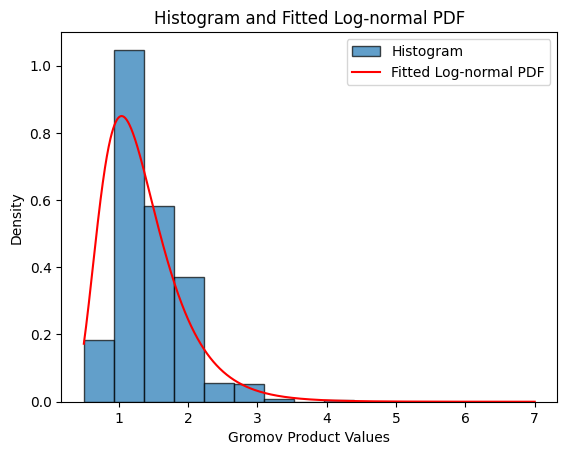

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

gp_cpu = gp.cpu().numpy()
gp_cpu = gp_cpu[gp_cpu > 0]

# Fit a log-normal distribution to the data
shape, loc, scale = lognorm.fit(gp_cpu, floc=0)  # fixing loc=0 for canonical log-normal

# Compute mean and variance of the fitted distribution
mean = lognorm.mean(shape, loc=loc, scale=scale)
variance = lognorm.var(shape, loc=loc, scale=scale)

# Compute histogram (normalized to form a density)
counts, bins = np.histogram(gp_cpu, bins=15, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Evaluate PDF at bin centers
pdf_vals = lognorm.pdf(bin_centers, shape, loc=loc, scale=scale)

# Compute Mean Squared Error
mse = np.mean((counts - pdf_vals) ** 2)

# Display results
print(f"Log-normal fit parameters: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Fitted log-normal mean: {mean:.4f}")
print(f"Fitted log-normal variance: {variance:.4f}")
print(f"MSE between histogram and fitted PDF: {mse:.6f}")

# Plot histogram and fitted PDF
x = np.linspace(min(gp_cpu), max(gp_cpu), 1000)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

plt.hist(gp_cpu, bins=15, edgecolor='black', alpha=0.7, density=True, label='Histogram')
plt.plot(x, pdf, 'r-', label='Fitted Log-normal PDF')
plt.xlabel('Gromov Product Values')
plt.ylabel('Density')
plt.title('Histogram and Fitted Log-normal PDF')
plt.legend()
plt.show()
